# Sistema de predicción de ventas

### Paso 1: Carga del conjunto de datos

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [52]:
data = pd.read_csv('/Users/julian/Desktop/vs code/TIME_SERIES_FORECASTING_Sistema_de_predicción_de_ventas_Project_23_Julian_Lopez/TIME_SERIES_FORECASTING_Sistema_de_predicci-n_de_ventas_Project_23_Julian_Lopez/data/raw/sales.csv')
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [53]:
data.shape

(366, 2)

In [54]:
data.isnull().sum()

date     0
sales    0
dtype: int64

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [56]:
data.duplicated().sum()

0

### Paso 2: Construye y analiza la serie temporal

#### Construyo la estructura de datos válida para la serie temporal

In [57]:
data['date'] = pd.to_datetime(data['date'])

In [58]:
data.set_index('date', inplace=True)

In [59]:
final_data = data["sales"]
final_data.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

#### Visualizo la serie temporal para llevar a cabo un análisis visual

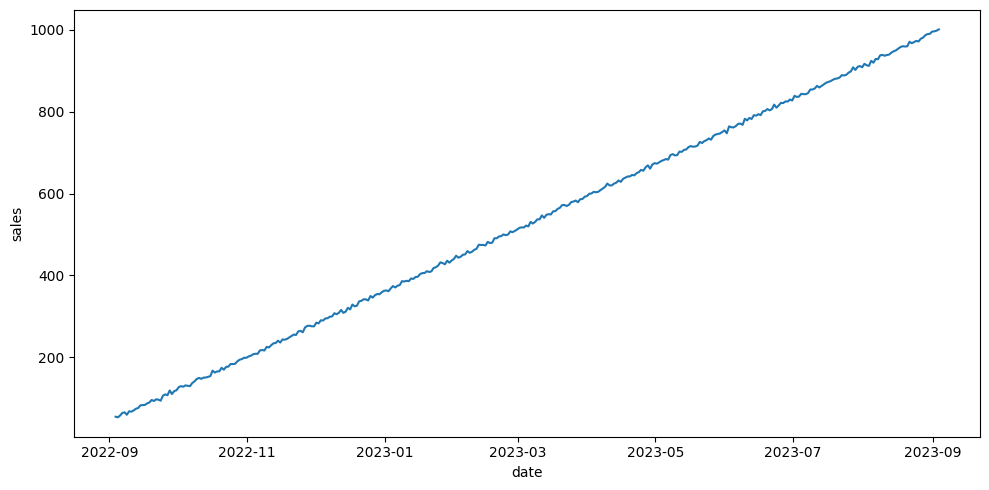

In [60]:

import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)

plt.tight_layout()

plt.show()

#### ¿Cuál es el tensor de la serie temporal?

Si no se especifica un número de pasos de tiempo (timesteps), la forma del tensor es simplemente una representación de la serie temporal tal cual, que en este caso es de dimensión (366, 1), donde:
366 es el número de datos (un dato por día).
1 es la cantidad de características (en este caso, solo sales).

#### Descoposición de la serie


In [61]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(final_data, period = 12)
decomposition

#### ¿Cuál es la tendencia?

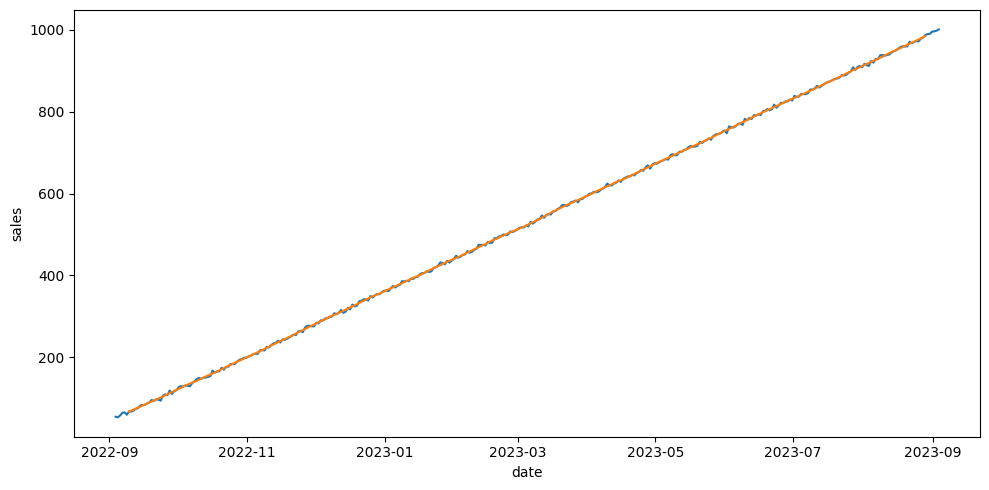

In [62]:
# Análisis de la tendencia

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()


Se confirma lo observado: una clara tendencia positiva a lo largo de los días.

#### ¿Es estacionaria?

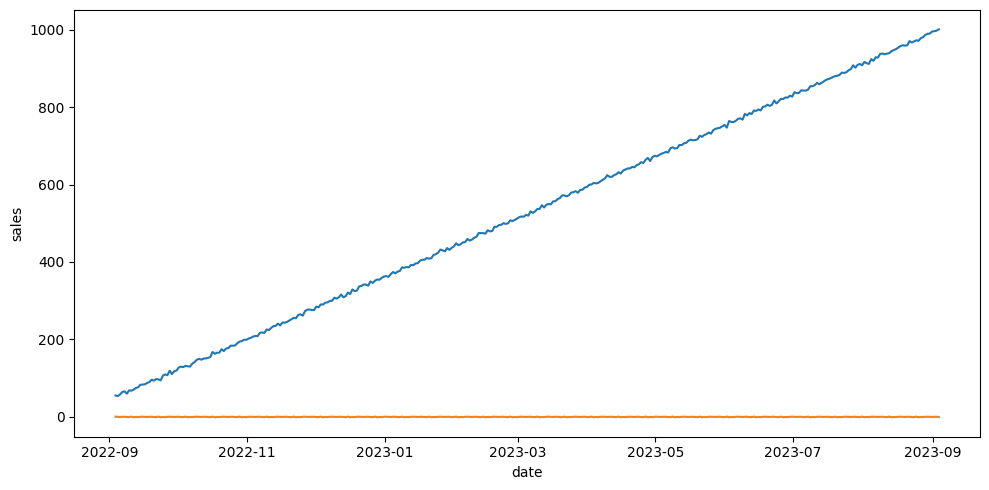

In [63]:
# Análisis de la estacionalidad

seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [64]:
# Prueba de Dickey-Fuller (Dickey-Fuller test)

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(final_data)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

#### ¿Existe variabilidad o presencia de ruido?

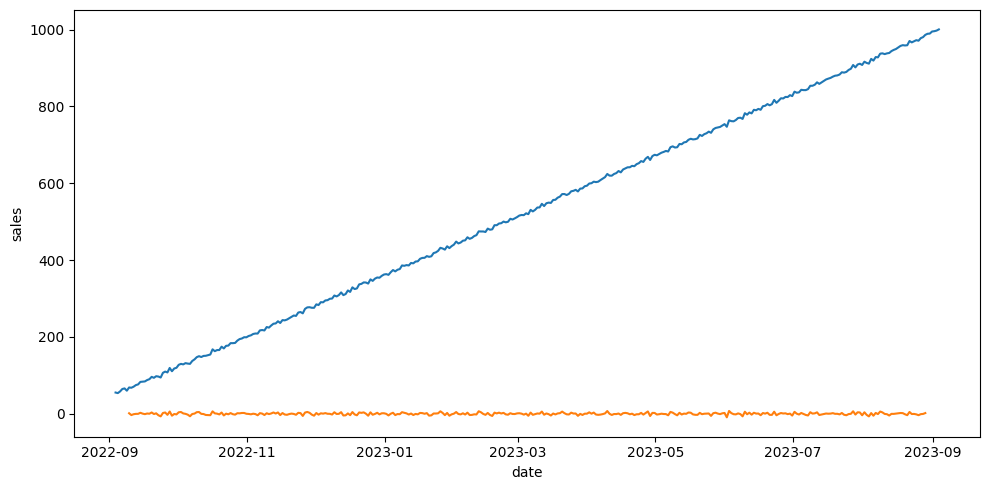

In [65]:
# Análisis de la variabilidad

residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Como obserbamos, si existe variabilidad o presencia de ruido. Hay ruido en la serie, como se observa en los residuos después de la descomposición. Estas fluctuaciones no siguen una estructura clara y están centradas en cero, lo cual indica variabilidad aleatoria que no puede explicarse por la tendencia ni por un patrón estacional.

#### Análisis de la autocorrelación

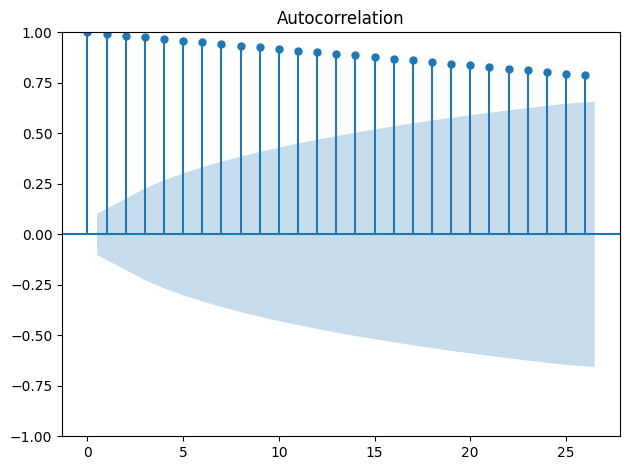

In [66]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(final_data)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye poco a poco a lo largo del tiempo.

### Paso 3: Entrena un ARIMA

In [67]:
final_data_stationary = final_data.diff().dropna()

test_stationarity(final_data_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [68]:
from pmdarima import auto_arima

model = auto_arima(final_data_stationary, seasonal = False, trace = True, m = 366)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1855.630, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2209.657, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2205.881, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2208.143, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (366) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/l

 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1857.273, Time=0.09 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1843.049, Time=0.10 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1843.587, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1841.533, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1839.553, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1839.587, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.00 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pytho

 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1839.608, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1922.649, Time=0.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.191 seconds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [69]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Mon, 07 Apr 2025   AIC                           1839.553
Time:                        14:44:06   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Paso 4: Predice con el conjunto de test

In [72]:
# Predicción del modelo

forecast = model.predict(10)
forecast

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-09-04 17:10:08.079328    1.675366
2023-09-05 17:10:08.079328    2.673520
2023-09-06 17:10:08.079328    2.591621
2023-09-07 17:10:08.079328    2.598341
2023-09-08 17:10:08.079328    2.597789
2023-09-09 17:10:08.079328    2.597834
2023-09-10 17:10:08.079328    2.597831
2023-09-11 17:10:08.079328    2.597831
2023-09-12 17:10:08.079328    2.597831
2023-09-13 17:10:08.079328    2.597831
Freq: D, dtype: float64

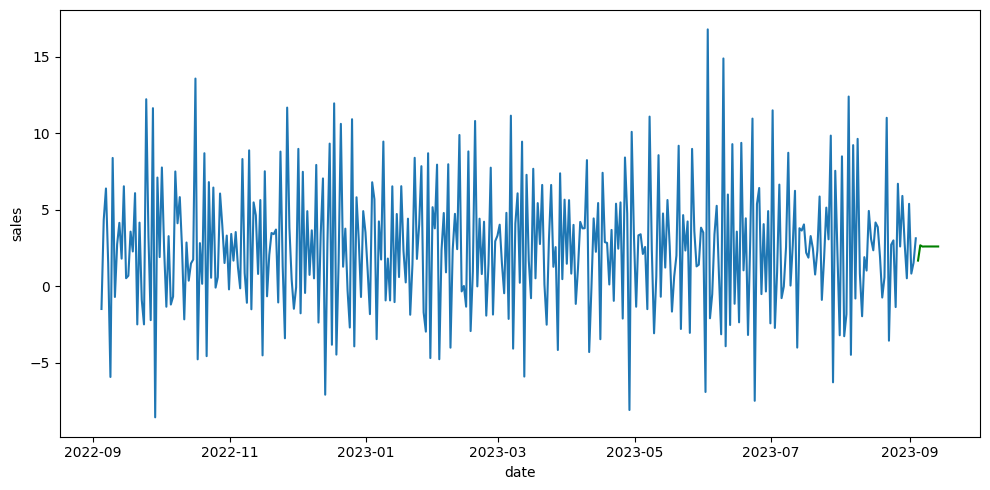

In [73]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

#### Guardar el modelo

In [75]:
with open("/Users/julian/Desktop/vs code/TIME_SERIES_FORECASTING_Sistema_de_predicción_de_ventas_Project_23_Julian_Lopez/TIME_SERIES_FORECASTING_Sistema_de_predicci-n_de_ventas_Project_23_Julian_Lopez/models/Model_auto_arima.pkl", "wb") as file:
  pickle.dump(model, file)
